In [6]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

In [7]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190703_syt488_vglut635P_tnr580/'
protein="TNR" #TNR,Agg,WFA,HABP

In [8]:
results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "sytchannelno":[],
           "vglutchannelno":[],
           "Manual vglut spots mask":[],
           "Manual syt1 spots mask":[],
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    #if "_analyse" in str(filelist[i]):
        #print(1)
        if "2019" in str(filelist[i]):
            #print(2)
            if ("Pop" in str(filelist[i]))==False:
                #print(3)
                if ("save" in str(filelist[i]))==False:
                    #print(4)
                    if ("spot" in str(filelist[i]))==False:
                        if ("TIFs_analyse copy" in str(filelist[i]))==False:
                            #if ("samecell" in str(filelist[i]))==False:
                            
                            #print(5)
                                if filelist[i].endswith(".tif"): 
                                #print(6)
                                    if "\\" in str(filelist[i]):
                                        #print(7)
                                        if (('/').join(filelist[i].split('\\')[:-1])+'\\\\'+filelist[i][:-12].split('\\')[-1] in str(results["filename"]))==False:
                                            print(filelist[i])
                                            results["filename"].append(filelist[i][:-12])
                                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                                            results["sytchannelno"].append(3)
                                            results["ecmchannelno"].append(2)
                                            results["vglutchannelno"].append(1)
                                    elif (str(filelist[i][:-12]) not in str(results["filename"]))==True:
                                        #print(8)
                                        results["filename"].append(filelist[i][:-12])
                                        results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                                        results["sytchannelno"].append(3)
                                        results["ecmchannelno"].append(2)
                                        results["vglutchannelno"].append(1)

## Loading a random image

Image name: 7_ExpControl
Experimental condition: TIF_imp


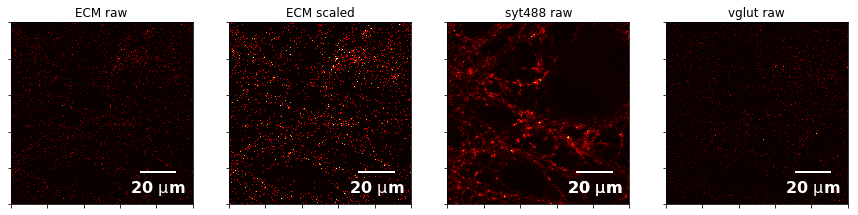

In [9]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
syt_channel_no=results["sytchannelno"][randomno]
vglut_channel_no=results["vglutchannelno"][randomno]

ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
syt_image_name=results["filename"][randomno]+" Ch"+str(syt_channel_no)+" {0}.tif"
vglut_image_name=results["filename"][randomno]+" Ch"+str(vglut_channel_no)+" {0}.tif"


print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
syt_image=pims.open(syt_image_name)[0]
vglut_image=pims.open(vglut_image_name)[0]
#autofluorescence_image=pims.open(autofluorescence_image_name)[0]

figure=plt.figure(figsize=(15,15))
figure.add_subplot(141)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(142)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(143)
plt.imshow(syt_image,interpolation='none',cmap='hot')
plt.title('syt488 raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

plt.gca().add_artist(scalebar)

figure.add_subplot(144)
plt.imshow(vglut_image,interpolation='none',cmap='hot')
plt.title('vglut raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## Find spots

### Manual

In [10]:
#make empty masks
for i in range(0,len(results["filename"])):
    results["Manual vglut spots mask"].append(np.nan)
    results["Manual syt1 spots mask"].append(np.nan)

### For vglut channel

In [11]:
import ipywidgets as widgets
from ipywidgets import interact
first=0

#load first image
vglut_channel_no=results["vglutchannelno"][first]
vglut_image_name=results["filename"][first]+" Ch"+str(vglut_channel_no)+" {0}.tif"


vglut_image=pims.open(vglut_image_name)[0]
vglut_spots=deepcopy(vglut_image)
vglut_spots=ndi.median_filter(vglut_spots,size=5)

lower_man_threshold=np.min(vglut_spots)
upper_man_threshold=np.max(vglut_spots)

def f(Threshold,Manual_Threshold,Open,Close,Image_no):
    
    ii=Image_no
    vglut_channel_no=results["vglutchannelno"][ii]
    vglut_image_name=results["filename"][ii]+" Ch"+str(vglut_channel_no)+" {0}.tif"

    vglut_image=pims.open(vglut_image_name)[0]
    #bandpass (subtract gaussian filter)
    #lowpass = ndi.gaussian_filter(vglut_image, 3)
    #vglut_image = vglut_image - lowpass
    #vglut_image[vglut_image<0]=0
    
    vglut_spots=deepcopy(vglut_image)
    lower_man_threshold=np.min(vglut_spots)
    upper_man_threshold=np.max(vglut_spots)

    if Threshold=="Li":
        vglut_image_threshold=threshold_li(vglut_image)      
    if Threshold=="Otsu":
        vglut_image_threshold=threshold_otsu(vglut_image)
    if Threshold=="Manual":
        vglut_image_threshold=Manual_Threshold
    
    vglut_spots[vglut_spots<vglut_image_threshold]=0
    vglut_spots=ndi.binary_opening(vglut_spots,iterations=Open)
    vglut_spots=ndi.binary_closing(vglut_spots,iterations=Close)
    results["Manual vglut spots mask"][ii]=vglut_spots
    fig=plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.imshow(vglut_spots)
    plt.imshow(vglut_image,alpha=0.5,cmap='inferno')
    fig.add_subplot(122)
    plt.imshow(vglut_image,cmap='inferno')
    

#widgets
Threshold=widgets.Dropdown(options=["Li","Otsu","Manual"])
Manual_Threshold=widgets.IntSlider(min=lower_man_threshold,max=upper_man_threshold,step=1,value=lower_man_threshold)
Open=widgets.IntText(min=0,max=20,step=1,value=1)
Close=widgets.IntText(min=0,max=20,step=1,value=1)
Image_no=widgets.IntText(min=0,max=len(results["filename"]),value=0)

w=interact(f,Threshold=Threshold,Manual_Threshold=Manual_Threshold,Open=Open,Close=Close,
           Image_no=Image_no)

interactive(children=(Dropdown(description='Threshold', options=('Li', 'Otsu', 'Manual'), value='Li'), IntSlid…

### Backup manual spots for vglut

In [12]:
for image in range(0,len(results["filename"])):
    np.save(results["filename"][image]+'_vglut_spots_mask.npy',results["Manual vglut spots mask"][image])

### For syt channel

In [13]:
import ipywidgets as widgets
from ipywidgets import interact
first=0

#load first image
syt_channel_no=results["sytchannelno"][first]
syt_image_name=results["filename"][first]+" Ch"+str(syt_channel_no)+" {0}.tif"


syt_image=pims.open(syt_image_name)[0]
syt_spots=deepcopy(syt_image)
syt_spots=ndi.median_filter(syt_spots,size=5)

lower_man_threshold=np.min(syt_spots)
upper_man_threshold=np.max(syt_spots)

def f(Threshold,Manual_Threshold,Open,Close,Image_no):
    
    ii=Image_no
    syt_channel_no=results["sytchannelno"][ii]
    syt_image_name=results["filename"][ii]+" Ch"+str(syt_channel_no)+" {0}.tif"

    syt_image=pims.open(syt_image_name)[0]
    #bandpass (subtract gaussian filter)
    #lowpass = ndi.gaussian_filter(syt_image, 3)
    #syt_image = syt_image - lowpass
    #syt_image[syt_image<0]=0
    
    syt_spots=deepcopy(syt_image)
    lower_man_threshold=np.min(syt_spots)
    upper_man_threshold=np.max(syt_spots)

    if Threshold=="Li":
        syt_image_threshold=threshold_li(syt_image)      
    if Threshold=="Otsu":
        syt_image_threshold=threshold_otsu(syt_image)
    if Threshold=="Manual":
        syt_image_threshold=Manual_Threshold
    
    syt_spots[syt_spots<syt_image_threshold]=0
    syt_spots=ndi.binary_opening(syt_spots,iterations=Open)
    syt_spots=ndi.binary_closing(syt_spots,iterations=Close)
    results["Manual syt1 spots mask"][ii]=syt_spots
    fig=plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.imshow(syt_spots)
    plt.imshow(syt_image,alpha=0.5,cmap='inferno')
    fig.add_subplot(122)
    plt.imshow(syt_image,cmap='inferno')
    

#widgets
Threshold=widgets.Dropdown(options=["Li","Otsu","Manual"])
Manual_Threshold=widgets.IntSlider(min=lower_man_threshold,max=upper_man_threshold,step=1,value=lower_man_threshold)
Open=widgets.IntText(min=0,max=20,step=1,value=1)
Close=widgets.IntText(min=0,max=20,step=1,value=1)
Image_no=widgets.IntText(min=0,max=len(results["filename"]),value=0)

w=interact(f,Threshold=Threshold,Manual_Threshold=Manual_Threshold,Open=Open,Close=Close,
           Image_no=Image_no)

interactive(children=(Dropdown(description='Threshold', options=('Li', 'Otsu', 'Manual'), value='Li'), IntSlid…

### Back up the syt masks

In [14]:
for image in range(0,len(results["filename"])):
    np.save(results["filename"][image]+'_syt1_spots_mask.npy',results["Manual syt1 spots mask"][image])